# 1. Install dependencies and libraries

In [1]:
import os
import numpy as np
from skimage import io
import skimage
import skimage.transform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import pandas as pd

# 2. Load Images

### 2.1. Load image directories into numpy arrays

In [2]:
for root, _, files in os.walk("English\\Img\\GoodImg\\Bmp", topdown=False):
     if root[-3:] == '009':
        arr_009 = np.array([root+ '\\' + i for i in files])
     elif root[-3:] == '017':
        arr_017 = np.array([root+ '\\' + i for i in files])
     elif root[-3:] == '051':
        arr_051 = np.array([root+ '\\' + i for i in files])
     elif root[-3:] == '053':
        arr_053 = np.array([root+ '\\' + i for i in files])

### 2.2 Check the start and end of each array for labelling afterwards

In [3]:
print(len(arr_009), len(arr_017), len(arr_051), len(arr_053) ) 
## from 0 --> 31: 009
## from 32 (+142) --> 174: 017
## from 174 (+148) --> 323: 051
## from 323 (+54) --> 377: 053

32 143 148 54


### 2.3 Merge the 4 arrays into 1

In [4]:
args = (arr_009, arr_017, arr_051, arr_053)
all_arr = np.concatenate(args)

# 3. Reading the images

### 3.1. read the images as is using skimage

In [5]:
########## normal images ##########
imgs_all = []
for i in all_arr:
    imgs_all.append(io.imread(i))

### 3.2. Gray-scaling the images

In [6]:
########### gray images #########
imgs_gray = []
for i in imgs_all:
    imgs_gray.append(skimage.color.rgb2gray(i))

<ipython-input-6-00e47854b4d5>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  imgs_gray.append(skimage.color.rgb2gray(i))


#### 3.2.1. Sample for the output gray images

377

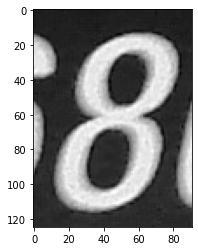

In [7]:
plt.imshow(imgs_gray[0], cmap = plt.cm.gray)
len(imgs_all)

### 3.3. Resizing the images to one size ==> 128x128
- I chose 128x128 as it didn't distort the images so much 

In [8]:
######## resize images ###########
imgs_resize = []
for i in imgs_gray:
    imgs_resize.append(skimage.transform.resize(i, (128,128), preserve_range=True))

#### 3.3.1. Sample for the resized images

377

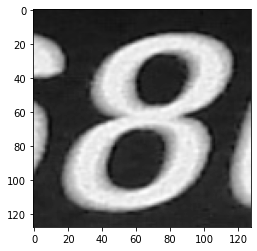

In [9]:
plt.imshow(imgs_resize[0], cmap = plt.cm.gray)
len(imgs_resize)

# 4. Labelling 

In [10]:
y = np.zeros(len(all_arr))
y[0:32] = 0 
y[32:175] = 1
y[175:323] = 2
y[323:377] = 3

#### 4.1. Checking the start of each label (to validate it's correct)

In [11]:
print(y[32], all_arr[32])
print(y[175], all_arr[175])
print(y[323], all_arr[323])

1.0 English\Img\GoodImg\Bmp\Sample017\img017-00001.png
2.0 English\Img\GoodImg\Bmp\Sample051\img051-00001.png
3.0 English\Img\GoodImg\Bmp\Sample053\img053-00001.png


# 5. Binary Classifier:
### 1st ==> between '8' ang 'G'

### Step 1: Specify X and Y 

In [12]:
x_1 = imgs_resize[0:175]
y_1 = y[0:175]

### Step 2: Split the data 'Randomly' using "train_test_split"
#### step 2.1: Split the whole data into train and test sets ==> 80% train-20% test

In [13]:
x_train11, x_test1, y_train11, y_test1 = train_test_split(x_1, y_1, test_size=0.2, random_state=42, shuffle = True)
print(len(x_train11), len(x_test1))

140 35


#### step 2.2. Split the train data -in the same manner- into train and validation sets ==> 80% train-20% validation

In [14]:
x_train1, x_valid1, y_train1, y_valid1 = train_test_split(x_train11, y_train11, test_size=0.2, random_state=42, shuffle = True)
print(len(x_train1), len(x_valid1))

112 28


- Split method: Random
- Size of the three splits: From the whole data==> Train set: 64% (112 img),  Validation set: 16%(28 img)  Test set: 20%(35 img)

### Step 3: Flatten the data arrays to fit the model
- The logistic regression model threw an error without flattening (3D not compitable)

In [15]:
def arr_flat (arr):
    ## to flatten each image; (-1) the last 2 dimensions
    arr = np.array(arr).reshape(len(arr), -1)
    return arr

x_train1 = arr_flat(x_train1)
x_valid1 = arr_flat(x_valid1)
x_test1 = arr_flat(x_test1)

In [16]:
print(len(x_train1))
print(len(x_train1[0]))

112
16384


### Step 4: Fitting the baseline logistic regression model
- Hyper parameters: 200 epochs, solver: 'liblinear', the 'saga' solver yielded very low metrices

In [17]:
clf = LogisticRegression(max_iter= 200, solver = 'liblinear', random_state=0).fit(x_train1, y_train1)

In [18]:
y_valid1 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])

- Here we can observe that the validation label had only one instance for class '0' which refers huge bias in the split

In [19]:
y_pred1 = clf.predict(x_valid1)

### Step 5: Confusion matrix

#### Step 5.1: Plot and print for the validation data

[[ 0  1]
 [ 1 26]]


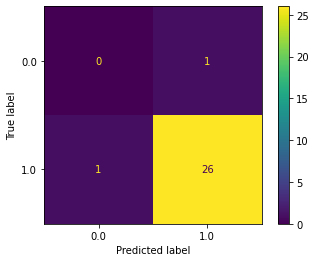

In [20]:
print(confusion_matrix(y_valid1, y_pred1))
plot_confusion_matrix(clf, x_valid1, y_valid1)  
plt.show()

#### Step 5.2: Plot and print for the test data

[[ 3  7]
 [ 0 25]]


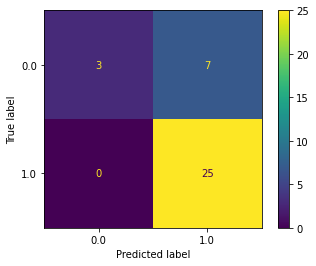

In [21]:
print(confusion_matrix(y_test1, clf.predict(x_test1)))
plot_confusion_matrix(clf, x_test1, y_test1)  
plt.show()

#### Step 5.3: Function for the metrices

In [22]:
### metrices
def metrices(tn, fp, fn, tp):
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = tp/(tp+fp)
    recall = tp/(tp+fn)
    return acc, prec, recall

#### Step 5.4: Print the values and calculate metrices
##### Step 5.4.1: For train data

In [23]:
### train data
tn, fp, fn, tp = confusion_matrix(y_train1, clf.predict(x_train1)).ravel()

In [24]:
acc1, prec1, recall1 = metrices(tn, fp, fn, tp)

In [25]:
print('Accuracy: {:.3f}'.format(acc1) , '\n','Precision: {:.3f}'.format(prec1), '\n', 'Recall: {:.3f}'.format(recall1))

Accuracy: 1.000 
 Precision: 1.000 
 Recall: 1.000


##### Step 5.4.2. For validation data

In [26]:
### validation data
tn, fp, fn, tp = confusion_matrix(y_valid1, y_pred1).ravel()

In [27]:
acc1, prec1, recall1 = metrices(tn, fp, fn, tp)

In [28]:
print('Accuracy: {:.3f}'.format(acc1) , '\n','Precision: {:.3f}'.format(prec1), '\n', 'Recall: {:.3f}'.format(recall1))

Accuracy: 0.929 
 Precision: 0.963 
 Recall: 0.963


##### Step 5.4.3. For test data

In [29]:
### test data
tn, fp, fn, tp = confusion_matrix(y_test1, clf.predict(x_test1)).ravel()

In [30]:
acc1, prec1, recall1 = metrices(tn, fp, fn, tp)

In [31]:
print('Accuracy: {:.3f}'.format(acc1) , '\n','Precision: {:.3f}'.format(prec1), '\n', 'Recall: {:.3f}'.format(recall1))

Accuracy: 0.800 
 Precision: 0.781 
 Recall: 1.000


In [32]:
y_test1

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       1.])

From the confusion matrix and the metrics we can apparently notice that: 
- The training data is perfectly fit (not suffering from underfitting) as all metrics are 1
- The validation data is also perfectly fit with above 90% metrics which is good
- However, the true issue appears when we try on the test data, where the problem regarding the bias in the data appears as the precision value is very low due to the scarcity of the negative class so it has a lot of instances that are falsely predicted as positive

### Step 6: ROC curve

#### Step 6.1. Function plot ROC curve

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=10, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc="lower right")
    plt.legend()

##### For training data

In [34]:
y_proba1 = clf.predict_proba(x_train1)[::,1]

In [35]:
fpr1, tpr1, thresholds = roc_curve(y_train1, y_proba1)

AUC: 1.000


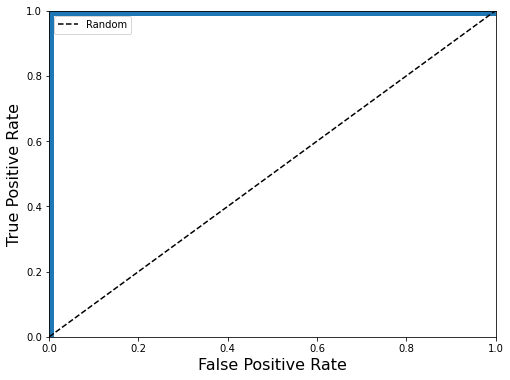

In [36]:
print('AUC: {:.3f}'.format(auc(fpr1, tpr1)))
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr1, tpr1)
plt.show()

##### For validation data

In [37]:
y_proba1 = clf.predict_proba(x_valid1)[::,1]

In [38]:
fpr1, tpr1, thresholds = roc_curve(y_valid1, y_proba1)

AUC: 0.000


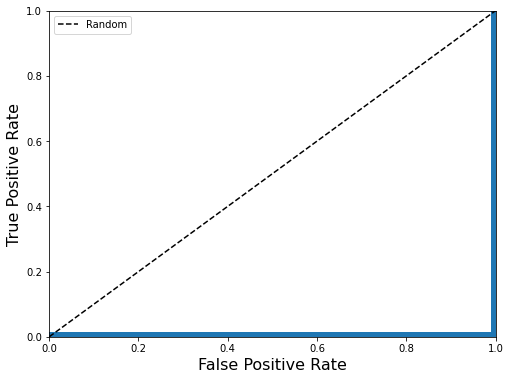

In [39]:
print('AUC: {:.3f}'.format(auc(fpr1, tpr1)))
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr1, tpr1)
plt.show()

##### For testing data

In [40]:
y_proba1 = clf.predict_proba(x_test1)[::,1]

In [41]:
fpr1, tpr1, thresholds = roc_curve(y_test1, y_proba1)

AUC: 0.472


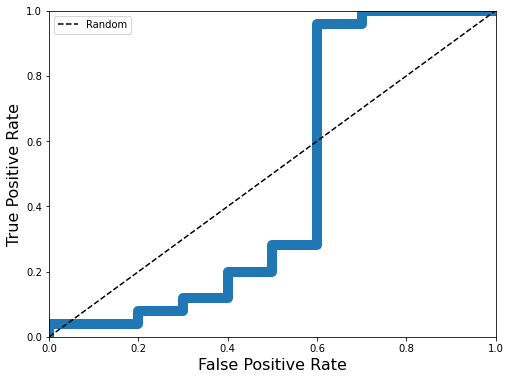

In [42]:
print('AUC: {:.3f}'.format(auc(fpr1, tpr1)))
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr1, tpr1)
plt.show()

From the ROCs and AUCs we can infer that the model is suffering from huge overfitting, so we need resampling for the data and hyperparameter tuning

## Step 2: Revisit

### Step 2: Stratified splitting (whole data==> 80-20; train-test, then: train-valid: 80-20)
#### Same percentage as random split

In [43]:
x_train1,  x_test1, y_train1, y_test1 = train_test_split(x_1, y_1, test_size=0.2, random_state=42, stratify = y_1)
x_train1,  x_valid1, y_train1, y_valid1 = train_test_split(x_train1, y_train1, test_size=0.2, random_state=42, stratify = y_train1)


- Split method: Stratified
- Size of the three splits: From the whole data==> Train set: 64% (112 img),  Validation set: 16%(28 img)  Test set: 20%(35 img), same as random split

### Step 3 repeat: Flatten

In [44]:
x_train1 = arr_flat(x_train1)
x_valid1 = arr_flat(x_valid1)
x_test1 = arr_flat(x_test1)

### Step 4 repeat: Fit the model with the stratified split data

In [45]:
clf_str = LogisticRegression(max_iter= 200, solver = 'liblinear', random_state=0).fit(x_train1, y_train1)

In [46]:
y_pred1 = clf_str.predict(x_valid1)

In [47]:
y_valid1 ### here more reasonable

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])

- Insight: the stratified split considered near rational/fair split rather than the random one; where class '0' appeared here more instead of only 1 instance as random split

#### Check if any change happened w.r.t test data

In [48]:
### test data
tn, fp, fn, tp = confusion_matrix(y_test1, clf_str.predict(x_test1)).ravel()

In [49]:
acc1, prec1, recall1 = metrices(tn, fp, fn, tp)

In [50]:
print('Accuracy: {:.3f}'.format(acc1) , '\n','Precision: {:.3f}'.format(prec1), '\n', 'Recall: {:.3f}'.format(recall1))

Accuracy: 0.800 
 Precision: 0.844 
 Recall: 0.931


[[ 1  5]
 [ 2 27]]


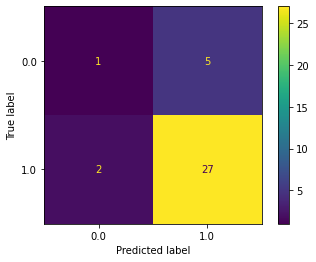

In [51]:
print(confusion_matrix(y_test1, clf_str.predict(x_test1)))
plot_confusion_matrix(clf_str, x_test1, y_test1)  
plt.show()

AUC: 0.644


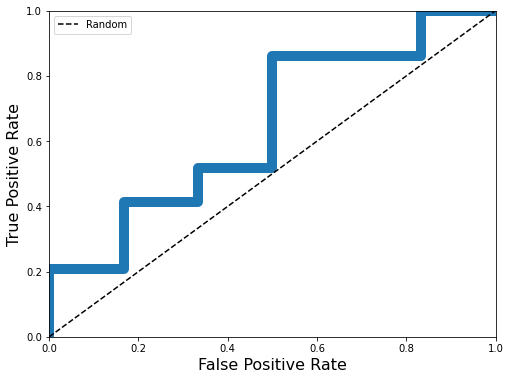

In [52]:
y_proba1 = clf_str.predict_proba(x_test1)[::,1]
fpr1, tpr1, thresholds = roc_curve(y_test1, y_proba1)
print('AUC: {:.3f}'.format(auc(fpr1, tpr1)))
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr1, tpr1)
plt.show()

- Apparently with stratified split the precision increased since it kept -to some extent- good distribution between the two classes and accordingly the AUC, which indicates the necessity of keeping a balanced data and in the different splits

## Repeat Binary classifier: for 'O' and 'Q'

### Step 1: Specify the data

In [53]:
x_2 = imgs_resize[175:]
y_2 = y[175:]

### Step 2: 
#### Step 2.1: Split the data, continue with stratified split, 80%-20% train-test 

In [54]:
x_train22, x_test2, y_train22, y_test2 = train_test_split(x_2, y_2, test_size=0.2, random_state=42, stratify = y_2, shuffle = True)
print(len(x_train22), len(x_test2))

161 41


#### Step 2.2: Split the train data into 80% train and 20% validation

In [55]:
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train22, y_train22, test_size=0.2, random_state=42, stratify = y_train22, shuffle = True)
print(len(x_train2), len(x_valid2))

128 33


- Split method: Stratified (as it yielded better results so we'll proceed with it) 
- Size of images: 128 imgs for train data, 33 for validation data and 41 for test data

### Step 3: Flatten

In [56]:
x_train2 = arr_flat(x_train2)
x_valid2 = arr_flat(x_valid2)
x_test2 = arr_flat(x_test2)

### Step 4: Fitting the model 

In [57]:
clf2 = LogisticRegression(max_iter= 500, solver = 'liblinear', random_state=0).fit(x_train2, y_train2)

In [58]:
y_pred2 = clf2.predict(x_valid2)

### Step 5: confusion matrix

#### Print the values and calculate metrices
##### For train data

In [59]:
### train data
tn, fp, fn, tp = confusion_matrix(y_train2, clf2.predict(x_train2)).ravel()

In [60]:
acc2, prec2, recall2 = metrices(tn, fp, fn, tp)

In [61]:
print('Accuracy: {:.3f}'.format(acc2) , '\n','Precision: {:.3f}'.format(prec2), '\n', 'Recall: {:.3f}'.format(recall2))

Accuracy: 1.000 
 Precision: 1.000 
 Recall: 1.000


[[94  0]
 [ 0 34]]


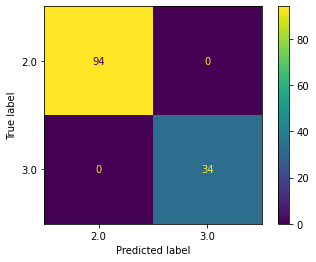

In [62]:
print(confusion_matrix(y_train2, clf2.predict(x_train2)))
plot_confusion_matrix(clf2, x_train2, y_train2)  
plt.show()

##### For valid data

In [63]:
### train data
tn, fp, fn, tp = confusion_matrix(y_valid2, clf2.predict(x_valid2)).ravel()

In [64]:
acc2, prec2, recall2 = metrices(tn, fp, fn, tp)

In [65]:
print('Accuracy: {:.3f}'.format(acc2) , '\n','Precision: {:.3f}'.format(prec2), '\n', 'Recall: {:.3f}'.format(recall2))

Accuracy: 0.727 
 Precision: 0.500 
 Recall: 0.111


In [66]:
y_valid2
y_pred2

array([3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

[[23  1]
 [ 8  1]]


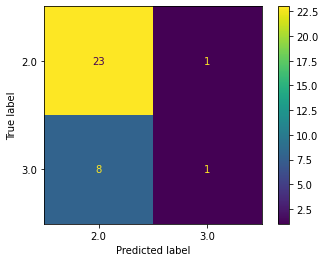

In [67]:
print(confusion_matrix(y_valid2, clf2.predict(x_valid2)))
plot_confusion_matrix(clf2, x_valid2, y_valid2)  
plt.show()

##### For test data

In [68]:
### test data
tn, fp, fn, tp = confusion_matrix(y_test2, clf2.predict(x_test2)).ravel()

In [69]:
acc2, prec2, recall2 = metrices(tn, fp, fn, tp)

In [70]:
print('Accuracy: {:.3f}'.format(acc2) , '\n','Precision: {:.3f}'.format(prec2), '\n', 'Recall: {:.3f}'.format(recall2))

Accuracy: 0.756 
 Precision: 0.556 
 Recall: 0.455


In [71]:
y_test2
clf2.predict(x_test2)

array([3., 2., 2., 3., 2., 2., 3., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2.,
       3., 2., 2., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 3., 3.])

#### Plot and print confusion matrix for test data

[[26  4]
 [ 6  5]]


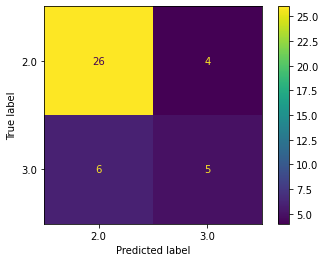

In [72]:
print(confusion_matrix(y_test2, clf2.predict(x_test2)))
plot_confusion_matrix(clf2, x_test2, y_test2)  
plt.show()

- Here we can observe that the model was overfitted with learning the class '2': letter 'O' where most of the negative (clas 3; Q) class were predicted -in the validation set- as positive (class 2; O)
- The problem continues in the test data but for both precision and recall which can tell about the confusion the model is suffering from as 'O' and 'Q' are very similar that this data needs a more complex model, needs to be more processed data in order to discriminate correctly between two very similar classes

### Step 6: ROC plot and AUC

##### For valid data

In [73]:
y_proba2 = clf2.predict_proba(x_valid2)[::,1]

In [74]:
fpr2, tpr2, thresholds = roc_curve(y_valid2, y_proba2, pos_label = 2)

AUC: 0.676


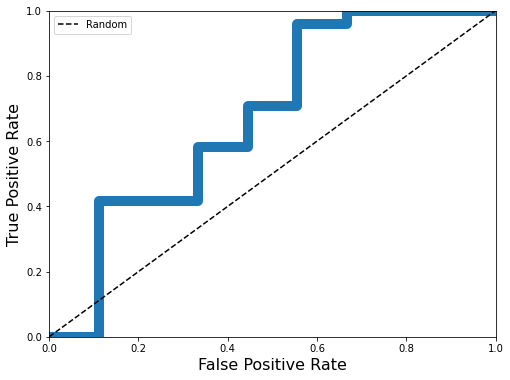

In [75]:
print('AUC: {:.3f}'.format(auc(fpr2, tpr2)))
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr2, tpr2)
plt.show()

##### For test data

In [76]:
y_proba2 = clf2.predict_proba(x_test2)[::,1]

In [77]:
fpr2, tpr2, thresholds = roc_curve(y_test2, y_proba2, pos_label = 2)

AUC: 0.436


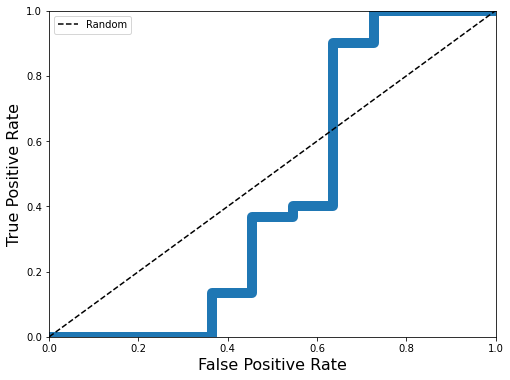

In [78]:
print('AUC: {:.3f}'.format(auc(fpr2, tpr2)))
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr2, tpr2)
plt.show()

- The ROC curves assures the problem in the validation and test data 

# Multi Classification

### Step 1: Specify the data

In [79]:
x_m = imgs_resize
y_m = y

### Step 2: Split the data -stratified- into train-test (80%-20%) then train-validation (80%-20%) 

In [80]:
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(x_m, y_m, test_size=0.2, random_state=42, stratify = y_m, shuffle = True)
print(len(x_train_m), len(x_test_m))

x_train_m, x_valid_m, y_train_m, y_valid_m = train_test_split(x_train_m, y_train_m, test_size=0.2, random_state=42, stratify = y_train_m, shuffle = True)
print(len(x_train_m), len(x_valid_m))

301 76
240 61


- Split Method: Stratified
- Size: train data (240 images), validation data (61 images) and test data (76 images)

### Step 3: Flatten

In [81]:
x_train_m = arr_flat(x_train_m)
x_valid_m = arr_flat(x_valid_m)
x_test_m = arr_flat(x_test_m)

### Step 4: Fitting the model into multi-class mode

In [82]:
clf_m = LogisticRegression(max_iter= 200, solver = 'liblinear', random_state=0, multi_class = 'auto').fit(x_train_m, y_train_m)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [83]:
y_pred_m = clf_m.predict(x_valid_m)

### Step 5: Confusion matrix 

#### Print the values and calculate metrices
##### For train data

[[21  0  0  0]
 [ 0 90  1  0]
 [ 0  0 94  0]
 [ 0  6  0 28]]


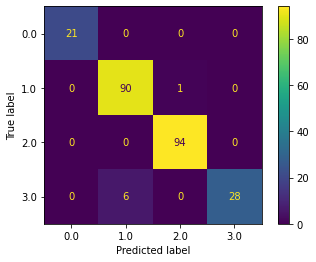

In [84]:
print(confusion_matrix(y_train_m, clf_m.predict(x_train_m)))
plot_confusion_matrix(clf_m, x_train_m, y_train_m)  
plt.show()

##### For validation data

[[ 2  1  2  0]
 [ 2 12  8  1]
 [ 0 11 13  0]
 [ 0  2  6  1]]


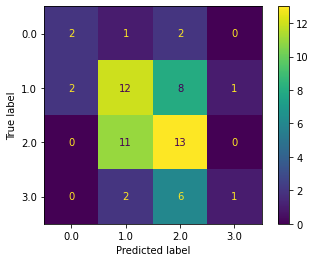

In [85]:
print(confusion_matrix(y_valid_m, clf_m.predict(x_valid_m)))
plot_confusion_matrix(clf_m, x_valid_m, y_valid_m)  
plt.show()

##### For test data

[[ 0  1  5  0]
 [ 0 13 16  0]
 [ 2 12 16  0]
 [ 1  5  5  0]]


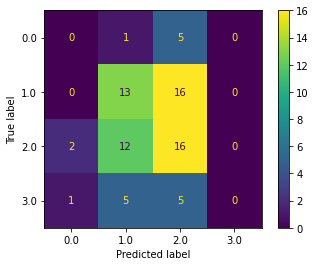

In [86]:
y_pred_test_m = clf_m.predict(x_test_m)
print(confusion_matrix(y_test_m, y_pred_test_m))
plot_confusion_matrix(clf_m, x_test_m, y_test_m)  
plt.show()

### Step 6: Metrices and ROC

#### Step 6.1: Metrics

#### Validation data

- The functions for the metrics in multiclass are taken from this paper: 
<https://arxiv.org/pdf/2008.05756.pdf#:~:text=Accuracy%20is%20one%20of%20the,computed%20from%20the%20confusion%20matrix.&text=The%20formula%20of%20the%20Accuracy,confusion%20matrix%20at%20the%20denominator.>

In [97]:
y_pred_valid_m = clf_m.predict(x_valid_m)
t0p0, t0p1, t0p2, t0p3, t1p0, t1p1, t1p2, t1p3, t2p0, t2p1, t2p2, t2p3, t3p0, t3p1, t3p2, t3p3 = confusion_matrix(y_valid_m, y_pred_valid_m).ravel()

tp_total = t0p0 + t1p1 +t2p2 + t3p3
samples_total = t0p0 + t0p1 + t0p2 + t0p3 + t1p0 + t1p1 + t1p2 + t1p3 + t2p0 + t2p1 + t2p2 + t2p3 + t3p0 + t3p1 + t3p2 + t3p3

## Rows resemble here the true 
row0 = t0p0 + t0p1 + t0p2 + t0p3
row1 = t1p0 + t1p1 + t1p2 + t1p3
row2 = t2p0 + t2p1 + t2p2 + t2p3
row3 = t3p0 + t3p1 + t3p2 + t3p3

## Cols resemble here the predictions
col0 = t0p0 +t1p0 + t2p0 + t3p0
col1 = t0p1 + t1p1 + t2p1 + t3p1
col2 = t0p2 + t1p2 + t2p2 + t3p2
col3 = t0p3  +t1p3 + t2p3 + t3p3 

In [98]:
acc_m = tp_total/samples_total

### Calculate precision for each class
prec_0 = t0p0 / col0
prec_1 = t1p1 / col1
prec_2 = t2p2 / col2
prec_3 = t3p3 / col3
# print(prec_0, prec_1, prec_2, prec_3)
## Average precision
avg_prec = (prec_0  + prec_1 + prec_2 + prec_3)/4


## Calculate the Recall of each class
rec_0 = t0p0 / row0
rec_1 = t1p1 / row1
rec_2 = t2p2 / row2
rec_3 = t3p3 / row3
# print(rec_0, rec_1, rec_2, rec_3)

# Average Recall
avg_rec = (rec_0 + rec_1  + rec_2 + rec_3)/4

## F1 score
f1_score = 2*(avg_prec * avg_rec) / (avg_prec + avg_rec)

## print the values
print('Accuracy: {:.3f}'.format(acc_m))
print('Average Precision: {:.3f}'.format(avg_prec))
print('Average Recall: {:.3f}'.format(avg_rec))
print('F1-Score: {:.3f}'.format(f1_score))


0.5 0.46153846153846156 0.4482758620689655 0.5
0.4 0.5217391304347826 0.5416666666666666 0.1111111111111111
Accuracy: 0.459
Average Precision: 0.477
Average Recall: 0.394
F1-Score: 0.432


#### Step 6.2: ROC and AUC

- Since the ROC curve works on binary data, one hot encoded one so we transform here the data from integer numbers to one-hot encoded values and plot each roc curve
- This was inspired by this answer here <https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification>

In [260]:
y_proba_valid_m = clf_m.predict_proba(x_valid_m)

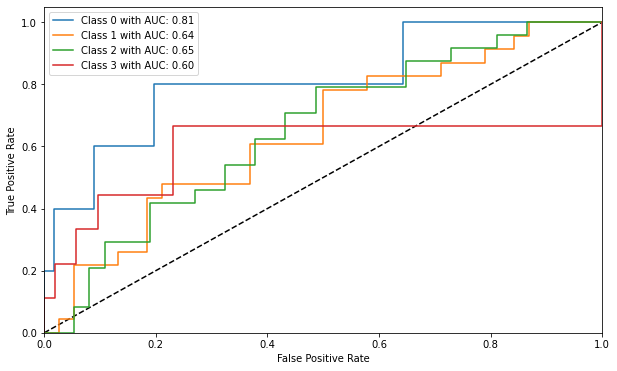

In [261]:
fpr_m = dict()
tpr_m = dict()
roc_auc_m = dict()

y_valid_m = pd.get_dummies(y_valid_m, drop_first=False).values

for i in range(4):
    fpr_m[i], tpr_m[i], _ = roc_curve(y_valid_m[:, i], y_proba_valid_m[:, i])
    roc_auc_m[i] = auc(fpr_m[i], tpr_m[i])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

for i in range(4):
    ax.plot(fpr_m[i], tpr_m[i], label='Class %i with AUC: %0.2f' % (i, roc_auc_m[i]))

ax.legend()
plt.show()

#### Test data

#### Step 6.1: Metrics

In [99]:
y_pred_test_m = clf_m.predict(x_test_m)
t0p0, t0p1, t0p2, t0p3, t1p0, t1p1, t1p2, t1p3, t2p0, t2p1, t2p2, t2p3, t3p0, t3p1, t3p2, t3p3 = confusion_matrix(y_test_m, y_pred_test_m).ravel()

tp_total = t0p0 + t1p1 +t2p2 + t3p3
samples_total = t0p0 + t0p1 + t0p2 + t0p3 + t1p0 + t1p1 + t1p2 + t1p3 + t2p0 + t2p1 + t2p2 + t2p3 + t3p0 + t3p1 + t3p2 + t3p3

row0 = t0p0 + t0p1 + t0p2 + t0p3
row1 = t1p0 + t1p1 + t1p2 + t1p3
row2 = t2p0 + t2p1 + t2p2 + t2p3
row3 = t3p0 + t3p1 + t3p2 + t3p3

col0 = t0p0 +t1p0 + t2p0 + t3p0
col1 = t0p1 + t1p1 + t2p1 + t3p1
col2 = t0p2 + t1p2 + t2p2 + t3p2
col3 = t0p3  +t1p3 + t2p3 + t3p3 


In [107]:
acc_m = tp_total/samples_total

prec_0 = t0p0 / col0
prec_1 = t1p1 / col1
prec_2 = t2p2 / col2
prec_3 = t3p3 / col3

### Since col3 = 0, then the prec_3 = ../0 which yields nan, so we convert it to 0 for simplicity but we should modify in the model
prec_3 = 0
avg_prec = (prec_0  + prec_1 + prec_2 + prec_3)/4
# print(prec_0, prec_1, prec_2, prec_3)


rec_0 = t0p0 / row0
rec_1 = t1p1 / row1
rec_2 = t2p2 / row2
rec_3 = t3p3 / row3
avg_rec = (rec_0 + rec_1  + rec_2 + rec_3)/4
# print(rec_0, rec_1, rec_2, rec_3)

f1_score = 2*(avg_prec * avg_rec) / (avg_prec + avg_rec)

print('Accuracy: {:.3f}'.format(acc_m))
print('Average Precision: {:.3f}'.format(avg_prec))
print('Average Recall: {:.3f}'.format(avg_rec))
print('F1-Score: {:.3f}'.format(f1_score))


0.0 0.41935483870967744 0.38095238095238093 0
0.0 0.4482758620689655 0.5333333333333333 0.0
Accuracy: 0.382
Average Precision: 0.200
Average Recall: 0.245
F1-Score: 0.220


<ipython-input-107-5f28d9a64375>:6: RuntimeWarning: invalid value encountered in longlong_scalars
  prec_3 = t3p3 / col3


#### Step 6.2: ROC curves

In [108]:
y_proba_test_m = clf_m.predict_proba(x_test_m)

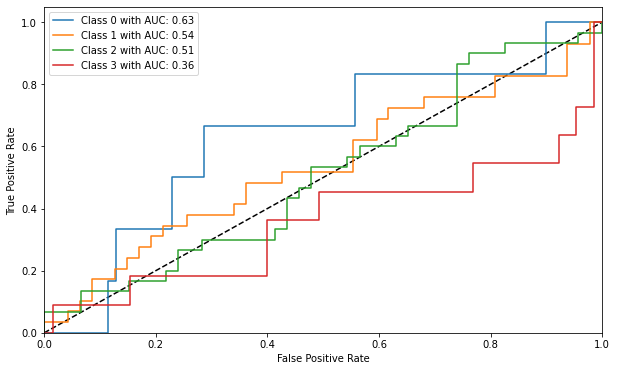

In [109]:
fpr_m = dict()
tpr_m = dict()
roc_auc_m = dict()

y_test_m = pd.get_dummies(y_test_m, drop_first=False).values

for i in range(4):
    fpr_m[i], tpr_m[i], _ = roc_curve(y_test_m[:, i], y_proba_test_m[:, i])
    roc_auc_m[i] = auc(fpr_m[i], tpr_m[i])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

for i in range(4):
    ax.plot(fpr_m[i], tpr_m[i], label='Class %i with AUC: %0.2f' % (i, roc_auc_m[i]))

ax.legend()
plt.show()

- Apparently from the previous we can see how awful the classifier works on multi classes, thus we need to perform more improvements on the model and the data to make it work better

- Further work: we should use the validation data for tuning different hyperparameters and then use the best set of hyperparameters to train the model with the train and validation data, use different image processing and try different classifiers especially CNNs that are known for their high performance in this contexts 